# This notebook was used for learning how to build a network graph and visualize it using holoviews.  

In [ ]:
import pprint
import json
import pathlib
import pandas as pd
import os
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import math
from random import sample
from collections import Counter

In [3]:
from libWill.helpers import *
# importlib.reload(helpers)
pp = pprint.PrettyPrinter(indent=4)

In [4]:
dirty_hourly = pathlib.Path('../../data/dirty/hourly/')
jsonl_files = os.listdir(dirty_hourly)

In [5]:
all_tweets = []

for file in jsonl_files:
    all_tweets.extend(filter_tweet_fields_as_dict(pathlib.Path(dirty_hourly,file)))

In [28]:
df = pd.DataFrame(all_tweets[0:20000])
df.tail()

created_at      screen_name  \
19995  Sat Oct 26 10:45:07 +0000 2019  the_crypto_feed   
19996  Sat Oct 26 10:45:06 +0000 2019      MaximumHODL   
19997  Sat Oct 26 10:45:06 +0000 2019  BullsBlockchain   
19998  Sat Oct 26 10:45:06 +0000 2019  BullsBlockchain   
19999  Sat Oct 26 10:45:05 +0000 2019      RastaCrypto   

                                               full_text   geo  \
19995  hard fork – the next web: satoshi nakaboto: ‘b...  None   
19996  CoinDesk: Bitcoin Price Hits Five-Week High Ab...  None   
19997  Bitcoin Price Hits Five-Week High Above $10,00...  None   
19998  Bitcoin Price Hits Five-Week High Above $10,00...  None   
19999  First time I remember the bitcoin price crossi...  None   

                        id lang  retweet_count rt_status_screen_name  \
19995  1188043877229330432   en              0                   NaN   
19996  1188043872787562496   en              0                   NaN   
19997  1188043870304522241   en              0                   NaN   
19998  1188043870304522241   en              0                   NaN   
19999  1188043866164867072   en              0                   NaN   

      rt_status_id mentions mention_ids  
19995          NaN       []          []  
19996          NaN       []          []  
19997          NaN       []          []  
19998          NaN       []          []  
19999          NaN       []          []

In [29]:
df = df[['created_at','screen_name','full_text','id','geo','lang','mention_ids','mentions','retweet_count','rt_status_id','rt_status_screen_name']]

In [205]:
df.head()

created_at      screen_name  \
0  Thu Oct 31 23:58:56 +0000 2019       Ricky_P007   
1  Thu Oct 31 23:58:56 +0000 2019  KennedyPattiso1   
2  Thu Oct 31 23:58:55 +0000 2019      BtcEthereum   
3  Thu Oct 31 23:58:52 +0000 2019    erickchan_XLM   
4  Thu Oct 31 23:58:50 +0000 2019     Researchiing   

                                           full_text                   id  \
0  RT @Delta_Exchange: How many coin logos do you...  1190055587255422977   
1  RT @XRPcryptowolf: Intercontinental Exchange (...  1190055584910991360   
2  Bitcoin Needs ‘Real Use Cases’ to Become Digit...  1190055581886775297   
3  @CyhChloe @johnkim77 @jasminecoin @codeyisfun ...  1190055568678895618   
4  RT @zerohedge: 11 Years Ago Today Satoshi Naka...  1190055561682964481   

    geo lang                                        mention_ids  \
0  None   en                               [994891951160864769]   
1  None   en                               [944462285573099520]   
2  None   en                                                 []   
3  None   en  [1059871115236073473, 26448153, 11864798016930...   
4  None   en                                         [18856867]   

                                            mentions  retweet_count  \
0                                   [Delta_Exchange]              0   
1                                    [XRPcryptowolf]              0   
2                                                 []              0   
3  [CyhChloe, johnkim77, jasminecoin, codeyisfun,...              0   
4                                        [zerohedge]              0   

         rt_status_id rt_status_screen_name  community  
0  994891951160864769        Delta_Exchange          0  
1  944462285573099520         XRPcryptowolf          1  
2                 NaN                   NaN          2  
3                 NaN                   NaN          3  
4            18856867             zerohedge          4

In [31]:
df_network = df[['screen_name','mentions','rt_status_screen_name']]
df_network.head()

screen_name                                           mentions  \
0       Ricky_P007                                   [Delta_Exchange]   
1  KennedyPattiso1                                    [XRPcryptowolf]   
2      BtcEthereum                                                 []   
3    erickchan_XLM  [CyhChloe, johnkim77, jasminecoin, codeyisfun,...   
4     Researchiing                                        [zerohedge]   

  rt_status_screen_name  
0        Delta_Exchange  
1         XRPcryptowolf  
2                   NaN  
3                   NaN  
4             zerohedge

In [63]:
smallnet = df_network
smallnet.tail()


screen_name mentions rt_status_screen_name
19995  the_crypto_feed       []                   NaN
19996      MaximumHODL       []                   NaN
19997  BullsBlockchain       []                   NaN
19998  BullsBlockchain       []                   NaN
19999      RastaCrypto       []                   NaN

##Unpacking the mentions column to have multiple rows for each item in the mentions list

In [33]:
smallnet_exploded = smallnet.explode('mentions')

In [34]:
smallnet_exploded.reset_index(inplace=True,drop=True)

In [35]:
smallnet_exploded.tail()

screen_name mentions rt_status_screen_name
25418  the_crypto_feed      NaN                   NaN
25419      MaximumHODL      NaN                   NaN
25420  BullsBlockchain      NaN                   NaN
25421  BullsBlockchain      NaN                   NaN
25422      RastaCrypto      NaN                   NaN

In [36]:
edges = list(zip(smallnet_exploded['screen_name'],smallnet_exploded['mentions']))

In [37]:
edges = [t for t in edges if not any(isinstance(n, float) and math.isnan(n) for n in t)]

In [38]:
#print(edges)

In [39]:
twit_graph = nx.Graph()

In [40]:
twit_graph.add_nodes_from(smallnet['screen_name'])

In [41]:
twit_graph.add_edges_from(edges)

In [42]:
import community
parts = community.best_partition(twit_graph)
values = [parts.get(node) for node in twit_graph.nodes()]

In [44]:
node_list = list(twit_graph.nodes())
community_dict = { n:c for n,c in zip(node_list,values)}
nx.set_node_attributes(twit_graph, community_dict, 'community')

In [ ]:
screen_name_list = df['screen_name'].tolist()

In [69]:
df["community"] = df["screen_name"].map(community_dict)

In [203]:
df.tail()

created_at      screen_name  \
19995  Sat Oct 26 10:45:07 +0000 2019  the_crypto_feed   
19996  Sat Oct 26 10:45:06 +0000 2019      MaximumHODL   
19997  Sat Oct 26 10:45:06 +0000 2019  BullsBlockchain   
19998  Sat Oct 26 10:45:06 +0000 2019  BullsBlockchain   
19999  Sat Oct 26 10:45:05 +0000 2019      RastaCrypto   

                                               full_text                   id  \
19995  hard fork – the next web: satoshi nakaboto: ‘b...  1188043877229330432   
19996  CoinDesk: Bitcoin Price Hits Five-Week High Ab...  1188043872787562496   
19997  Bitcoin Price Hits Five-Week High Above $10,00...  1188043870304522241   
19998  Bitcoin Price Hits Five-Week High Above $10,00...  1188043870304522241   
19999  First time I remember the bitcoin price crossi...  1188043866164867072   

        geo lang mention_ids mentions  retweet_count rt_status_id  \
19995  None   en          []       []              0          NaN   
19996  None   en          []       []              0          NaN   
19997  None   en          []       []              0          NaN   
19998  None   en          []       []              0          NaN   
19999  None   en          []       []              0          NaN   

      rt_status_screen_name  community  
19995                   NaN         20  
19996                   NaN       3434  
19997                   NaN       1454  
19998                   NaN       1454  
19999                   NaN       3435

In [202]:
df['created_at'].dtype

dtype('O')

In [62]:
nx.number_of_nodes(twit_graph)

14902

In [24]:
nx.number_of_edges(twit_graph)

16227

In [83]:
drop_nodes = []
for i in twit_graph.nodes:
    if twit_graph.degree(i) < 3:
        drop_nodes.append(i)

In [84]:
twit_graph.remove_nodes_from(drop_nodes)

In [85]:
nx.number_of_nodes(twit_graph)

2480

In [86]:
import community
parts = community.best_partition(twit_graph)
values = [parts.get(node) for node in twit_graph.nodes()]

In [631]:
#print(community.__version__)

0.13


In [633]:
#! dir C:\Users\mferb\Anaconda3\envs\project2\lib\site-packages\community

In [634]:
#! conda list community

In [87]:
node_list = list(twit_graph.nodes())
community_dict = { n:c for n,c in zip(node_list,values)}
nx.set_node_attributes(twit_graph, community_dict, 'community')

In [ ]:
edge_dict = dict(twit_graph.degree)

In [126]:
nx.set_node_attributes(twit_graph,edge_dict,'num_edges')

In [134]:
max(edge_dict.values())

169

In [184]:
new_max = 50
new_min = 4
old_max = max(edge_dict.values())
old_min = min(edge_dict.values())

In [185]:
#node_size_scaled = [(((value for key,value in edge_dict.items() - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min]

In [186]:
node_size_scaled = []
for key,value in edge_dict.items():
    scaled_value= (((value - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    node_size_scaled.append(int(scaled_value))

In [187]:
scaled_nodes_dict = { n:c for n,c in zip(node_list,node_size_scaled)}
nx.set_node_attributes(twit_graph, scaled_nodes_dict, 'node_size')

In [188]:
from bokeh.io import show, save, output_file 
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral8
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
import holoviews as hv


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
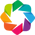

In [189]:
hv.extension('bokeh')

In [196]:
%opts Graph [width=800 height=800]
padding = dict(x=(-1.1, 1.1), y=(-1.1, 1.1))
twitter_graph = hv.Graph.from_networkx(twit_graph, nx.layout.kamada_kawai_layout)\
                .redim.range(**padding)\
                .options(color_index='community', cmap='Category20',node_size='node_size', edge_line_width=1,edge_line_color='#d3d3d3',)
                                        
hv.save(twitter_graph, 'holoview_kamada_layout.html')

In [195]:
twitter_graph

:Graph   [start,end]

In [125]:
#edge_dict

In [434]:
# #hover = HoverTool(tooltips=[('screen_name', twit_graph.nodes)])
                  
# plot = figure(title="5000 Tweets Test",
#               width=800,height=600,
#               tools=['box_zoom','pan','wheel_zoom','reset'], x_range=(-1.1,1.1), y_range=(-1.1,1.1))

# graph = from_networkx(twit_graph, nx.spring_layout, scale=3, center=(0,0))
# # graph.node_renderer.data_source = values

# graph.node_renderer.data_source.data['community'] = [i[1]['community'] for i in twit_graph.nodes(data=True)]
# graph.node_renderer.glyph = Circle(
#     size=10, 
#     fill_color=linear_cmap('community', 'Spectral8', 0, len(twit_graph.nodes()))
# )

# plot.renderers.append(graph)

# #output_file("5000_tweet_test_community.html")
# show(plot)

In [129]:
from holoviews.operation.datashader import datashade, bundle_graph


In [197]:
bundled = bundle_graph(twitter_graph)
bundled

:Graph   [start,end]

In [625]:
sorted(twit_graph.degree, key=lambda x: x[1], reverse=True)

[('APompliano', 80),
 ('Rhythmtrader', 65),
 ('realDonaldTrump', 36),
 ('CalvinAyre', 31),
 ('TheCryptoconomy', 30),
 ('Bitcoin_Beyond', 29),
 ('Cointelegraph', 28),
 ('saifedean', 27),
 ('Xentagz', 25),
 ('coindesk', 24),
 ('DesiCryptoHodlr', 23),
 ('pierre_rochard', 22),
 ('bitcoin_clara', 22),
 ('Twanomatic2', 20),
 ('kurtwuckertjr', 19),
 ('bitcoin_ug', 19),
 ('lopp', 19),
 ('NIXwhale', 19),
 ('ErikVoorhees', 19),
 ('Bitboy_Crypto', 19),
 ('aantonop', 19),
 ('CoinstorageGuru', 18),
 ('danheld', 18),
 ('Ragnarly', 18),
 ('american_hodl', 18),
 ('alistairmilne', 18),
 ('Bitcoin', 18),
 ('MichellePhan', 18),
 ('PeterSchiff', 18),
 ('Emperor_YZ', 17),
 ('Josh_Rager', 17),
 ('Poetry4Bitcoin', 17),
 ('dergigi', 17),
 ('Hermetec', 17),
 ('_blockandchain_', 17),
 ('bitstein', 17),
 ('TuurDemeester', 17),
 ('HotepJesus', 17),
 ('Capfolio', 17),
 ('EntangleIT', 16),
 ('eternalcrypto1', 16),
 ('Bitcoin_org_', 15),
 ('JimmyNLose', 15),
 ('_omohoje', 15),
 ('M_ednut', 15),
 ('johnkim77', 15),
 

In [163]:
community = nx.get_node_attributes(twit_graph,'Community')

In [175]:
largest_community = Counter(community['Bitcoin'])
largest_community.most_common()

[(8, 97),
 (30, 94),
 (7, 84),
 (5, 75),
 (112, 72),
 (0, 71),
 (3, 70),
 (27, 67),
 (60, 67),
 (21, 62),
 (24, 62),
 (35, 58),
 (57, 56),
 (31, 52),
 (9, 50),
 (14, 48),
 (205, 43),
 (12, 40),
 (33, 35),
 (74, 31),
 (11, 25),
 (278, 23),
 (22, 22),
 (37, 19),
 (64, 17),
 (130, 16),
 (1, 14),
 (15, 12),
 (18, 12),
 (125, 12),
 (56, 10),
 (114, 9),
 (174, 9),
 (299, 9),
 (2, 8),
 (50, 8),
 (13, 7),
 (29, 7),
 (49, 7),
 (68, 7),
 (106, 7),
 (163, 7),
 (190, 7),
 (281, 7),
 (372, 7),
 (23, 6),
 (48, 6),
 (66, 6),
 (71, 6),
 (72, 6),
 (113, 6),
 (135, 6),
 (176, 6),
 (244, 6),
 (266, 6),
 (331, 6),
 (19, 5),
 (20, 5),
 (26, 5),
 (38, 5),
 (42, 5),
 (46, 5),
 (53, 5),
 (54, 5),
 (69, 5),
 (93, 5),
 (103, 5),
 (120, 5),
 (122, 5),
 (133, 5),
 (151, 5),
 (154, 5),
 (184, 5),
 (294, 5),
 (459, 5),
 (4, 4),
 (16, 4),
 (36, 4),
 (39, 4),
 (45, 4),
 (67, 4),
 (83, 4),
 (85, 4),
 (91, 4),
 (126, 4),
 (138, 4),
 (139, 4),
 (140, 4),
 (149, 4),
 (159, 4),
 (167, 4),
 (180, 4),
 (197, 4),
 (204, 4),


In [178]:
print(len(community['Bitcoin']))

2632


In [176]:
nodes = list(twit_graph.nodes)

In [182]:
print(nodes[3])

Techcenterr


In [36]:
isolates = nx.isolates(twit_graph)

In [38]:
list(isolates)

['BtcEthereum',
 'RockstaTrading',
 'squatch_crypto',
 'FinTechNames',
 'PatriotCrypto',
 'BitBullCapital',
 'duniajalanjalan',
 'Etherbankingita',
 'Franzferdinan57',
 'ICOResearchGRP',
 'SportsbookBTC',
 'BitcoinCatz',
 'Crypt0Constella',
 'VoCtpgC8Ki241Rg',
 'KriptoKanalim',
 'webnowcompany',
 'coinbureau',
 'mospretmen',
 'ALTcoin_Ninjas',
 'bitlyfool',
 'retiredin2016',
 'HashDeploy',
 'TheeSeanH',
 'Lobaoal',
 'ShillHater',
 'ib_cpa',
 'AntonioSerbia',
 'SnowflakesAwwww',
 'Blacktradelines',
 'cryptogarten',
 'crypto__mak',
 'jadwahab',
 'HydaxE',
 'coinsonnews',
 'BizSoftwareEdu',
 'thecryptorep',
 'Ursalacher',
 'AinslieWealth',
 'TheSh0tC4ll3r',
 'InvestForward18',
 'icoinmarket1',
 'dragonwolftech',
 'robertdolci',
 'NachoThome',
 'DarkNodeGuru',
 'foxesden34',
 'BigCheds',
 'help_me_plzplz_',
 'News_1jl4',
 'Teokanistras',
 'PaulESamson',
 'AvyLorenCohen',
 'grbroker',
 'Cryptonetwealth',
 'GetCoinJar',
 'URBitcoinwear',
 'blockchainoshi',
 'bitcoin_jar',
 'FreeCryptoDeals',

In [71]:
twit_graph.remove_nodes_from(list(nx.isolates(twit_graph)))

In [72]:
nx.number_of_nodes(twit_graph)

3156

[('APompliano', 84),
 ('Rhythmtrader', 54),
 ('Cointelegraph', 38),
 ('jack', 29),
 ('100trillionUSD', 26),
 ('Bitcoin', 22),
 ('PeterSchiff', 21),
 ('qhfofficial', 20),
 ('BitCoin_Invest_', 20),
 ('Poetry4Bitcoin', 17),
 ('coindesk', 16),
 ('Hermetec', 16),
 ('Satoshis_D', 15),
 ('SammarA12281909', 13),
 ('Bitcoin_Beyond', 13),
 ('codeyisfun', 12),
 ('CalvinAyre', 11),
 ('TheCryptoconomy', 11),
 ('popesta', 11),
 ('realDonaldTrump', 11),
 ('Bakkt', 11),
 ('PeterMcCormack', 11),
 ('american_hodl', 11),
 ('CryptoOz', 10),
 ('Hanakookie1', 10),
 ('NemesisBSV', 10),
 ('Cripto_Bitcoin', 10),
 ('BTCTN', 10),
 ('StormIsUponUs', 10),
 ('ibmlahamad', 9),
 ('BitcoinEcon', 9),
 ('Coinicarus', 9),
 ('YobitsVision', 9),
 ('LomahCrypto', 9),
 ('Mihalbig', 9),
 ('Xentagz', 9),
 ('MZietzke', 9),
 ('Anders_', 9),
 ('trylolli', 9),
 ('HotepJesus', 9),
 ('HonorAfricans', 9),
 ('theonevortex', 8),
 ('InvestCrypForex', 8),
 ('Emperor_YZ', 8),
 ('channelBSV', 8),
 ('mindstatex', 8),
 ('pierre_rochard', 8),

In [85]:
nx.average_degree_connectivity(twit_graph)

{1: 6.369631236442516,
 3: 3.8732943469785575,
 2: 7.258947368421053,
 4: 4.375,
 9: 4.981481481481482,
 6: 2.8015873015873014,
 8: 3.46875,
 5: 2.9348837209302325,
 7: 4.333333333333333,
 84: 3.0357142857142856,
 11: 3.9220779220779223,
 10: 3.8333333333333335,
 13: 6.230769230769231,
 16: 2.875,
 15: 4.8,
 21: 6.761904761904762,
 17: 5.823529411764706,
 38: 1.9210526315789473,
 54: 1.5740740740740742,
 29: 2.0,
 22: 3.3181818181818183,
 20: 1.025,
 12: 1.8333333333333333,
 26: 2.923076923076923}

In [93]:
edges_for_node_x = twit_graph.degree('Rhythmtrader')

In [94]:
print(edges_for_node_x)

54


In [100]:
print(len(drop_nodes))

2780


In [204]:
print(len(community_dict))

2480
